# ИТОГОВАЯ АТТЕСТАЦИЯ / САМОЙЛОВ Н.С.

Программная инженерия. Разработка ПО (Аналитика: искусство управлять данными)

Был выбран датасет Mroz, который изначально был собран в рамках исследования женского труда и содержит социально-экономические данные, связанные с количеством часов работы замужних женщин, а также рядом переменных, таких как уровень образования, возраст, количество детей, семейный доход и прочие показатели. Данные использовались для анализа чувствительности моделей экономической активности женщин к различным экономическим и статистическим предположениям.

# 1. Загрузка необходимых библиотек

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.formula.api import ols
import statsmodels.api as sm

# 2. Загрузка данных

Данные будем загружать из пакета Ecdat, а конкретно из датасета Mroz.

In [56]:
item = 'Mroz'  # Выбранный датасет
package = 'Ecdat'  # Пакет, содержащий датасет

# Загрузка данных
df = sm.datasets.get_rdataset(item, package, cache=True).data

# 3. Обзор данных

Проведём анализ данных, чтобы посмотреть что в них, какой тип и как их можно использовать

In [57]:
print(df.head())
print(df.info())  # Для проверки доступных столбцов
print(df.describe())

  work  hoursw  child6  child618  agew  educw  hearnw  wagew  hoursh  ageh  \
0  yes    1610       1         0    32     12  3.3540   2.65    2708    34   
1  yes    1656       0         2    30     12  1.3889   2.65    2310    30   
2  yes    1980       1         3    35     12  4.5455   4.04    3072    40   
3  yes     456       0         3    34     12  1.0965   3.25    1920    53   
4  yes    1568       1         2    31     14  4.5918   3.60    2000    32   

   educh    wageh  income  educwm  educwf  unemprate city  experience  
0     12   4.0288   16310      12       7        5.0   no          14  
1      9   8.4416   21800       7       7       11.0  yes           5  
2     12   3.5807   21040      12       7        5.0   no          15  
3     10   3.5417    7300       7       7        5.0   no           6  
4     12  10.0000   27300      12      14        9.5  yes           7  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 753 entries, 0 to 752
Data columns (total 18 colu

Датасет включает 753 наблюдения с 22 переменными, среди которых:

- inlf: Индикатор участия в рабочей силе (1 - участвует, 0 - нет).
- hours: Часы работы за 1975 год.
- kidslt6: Количество детей младше 6 лет.
- kidsge6: Количество детей от 6 до 18 лет.
- educ: Годы обучения (образование).
- wage: Оценка заработной платы.
- faminc: Семейный доход.
- mtr: Федеральная маржинальная налоговая ставка.

Другие переменные касаются характеристик семьи и уровня безработицы в регионе.

# 4. Формулировка гипотез

а) Гипотеза о взаимосвязи двух категориальных переменных
- Гипотеза: "Существует взаимосвязь между наличием детей (child6) и городом проживания (city)"
- Логика: Считаем, что в городах с высоким уровнем урбанизации может быть больше детей, поскольку семья может позволить себе больше детей.
- Форма: Ожидаем, что частота наличия детей будет отличаться в зависимости от города проживания.

б) Гипотеза о взаимосвязи одной категориальной и одной числовой переменной
- Гипотеза: "Время работы (hoursw) зависит от образования (educw)"
- Логика: Считаем, что люди с более высоким уровнем образования работают больше часов, так как имеют более высокие должности.
- Форма: Ожидаем положительную корреляцию между уровнем образования и количеством рабочих часов.

в) Гипотеза о взаимосвязи двух числовых переменных
- Гипотеза: "Доход (income) зависит от количества рабочих часов (hoursw)"
- Логика: Более высокие рабочие часы должны приводить к большему доходу.
- Форма: Ожидаем положительную линейную зависимость между количеством рабочих часов и доходом.

# 5. Разведочный анализ данных

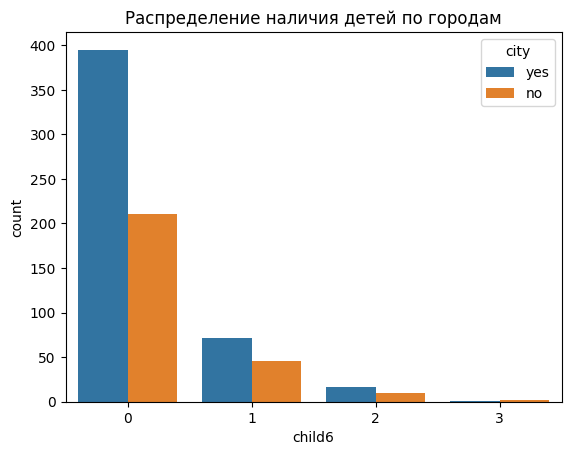

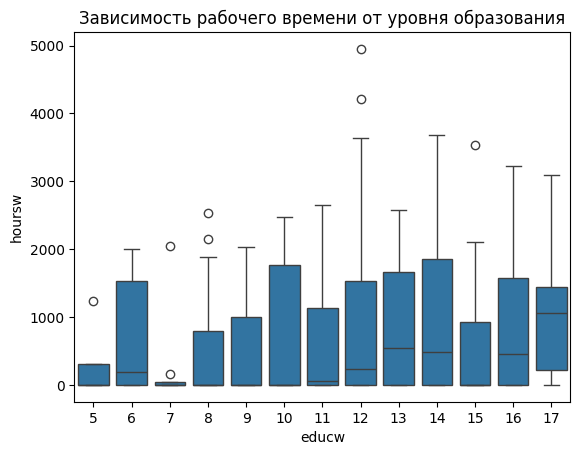

In [78]:
# a) Категориальные переменные
# График для гипотезы о взаимосвязи между наличием детей и городом
sns.countplot(data=df, x='child6', hue='city')
plt.title('Распределение наличия детей по городам')
plt.show()

# b) Числовые переменные
# Построим график для гипотезы о зависимости рабочего времени от образования
sns.boxplot(data=df, x='educw', y='hoursw')
plt.title('Зависимость рабочего времени от уровня образования')
plt.show()

- Среднее количество рабочих часов увеличивается с ростом уровня образования, что может быть связано с более высокими должностями и обязанностями.
- В уровнях с более высоким образованием наблюдается большая вариативность рабочих часов, что может отражать различные типы занятости и должностей в этих группах.
- В некоторых уровнях образования есть экстремально высокие значения рабочих часов, что может свидетельствовать о выбросах или аномальных значениях в данных

# 6. Очистка данных

In [79]:
# Проверим и очистим пропуски и выбросы
df_cleaned = df.dropna()  # Удаление строк с пропущенными значениями

# Для числовых переменных проверим выбросы
for col in df_cleaned.select_dtypes(include=[np.number]).columns:
    q1 = df_cleaned[col].quantile(0.25)
    q3 = df_cleaned[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)]

# 7. Тестирование распределения числовых переменных

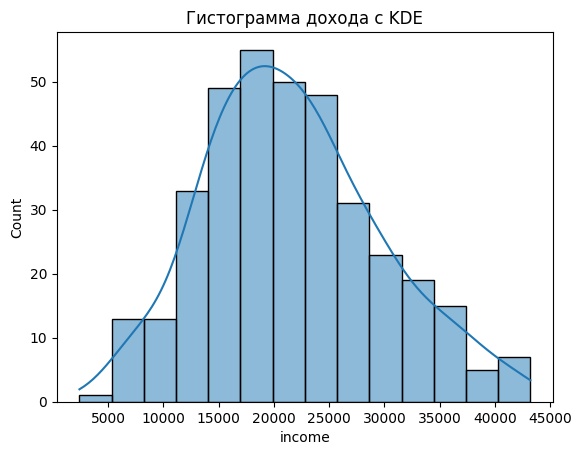

count      362.000000
mean     21689.411602
std       7950.514186
min       2400.000000
25%      16079.750000
50%      20987.000000
75%      26584.750000
max      43210.000000
Name: income, dtype: float64


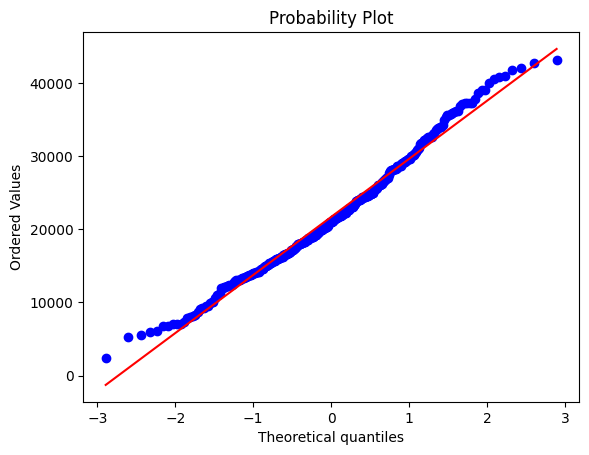

Shapiro-Wilk тест на нормальность: статистика = 0.9861505886794812, p-значение = 0.0015462709478609568


In [80]:
# Проверим, соответствует ли доход нормальному распределению
sns.histplot(df_cleaned['income'], kde=True)
plt.title('Гистограмма дохода с KDE')
plt.show()

# Получаем основные статистики по доходу
income_stats = df_cleaned['income'].describe()
print(income_stats)

# QQ-plot для проверки нормальности
stats.probplot(df_cleaned['income'], dist="norm", plot=plt)
plt.show()

# Получаем информацию о статистике теста для нормальности (например, для p-значения)
stat, p_value = stats.shapiro(df_cleaned['income'])
print(f"Shapiro-Wilk тест на нормальность: статистика = {stat}, p-значение = {p_value}")

Несмотря на визуальные признаки нормальности (гистограмма и QQ-график), результат теста Шапиро-Уилка свидетельствует о статистически значимом отклонении от нормального распределения. Это означает, что доход в наборе данных не следует нормальному распределению, и для дальнейших анализов или моделей может потребоваться преобразование данных или использование методов, которые не предполагают нормальности распределения.

# 8. Тесты гипотез

In [81]:
# а) Тест для двух категориальных переменных (хи-квадрат тест)
contingency_table = pd.crosstab(df_cleaned['child6'], df_cleaned['city'])
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
print(f"p-значение для теста хи-квадрат: {p}")

# б) Тест для одной категориальной и одной числовой переменной (ANOVA)
# Используем фильтрацию для выборки с достаточным размером группы
educw_values = df_cleaned['educw'].value_counts()[df_cleaned['educw'].value_counts() > 10].index
filtered_df = df_cleaned[df_cleaned['educw'].isin(educw_values)]

# Теперь выполняем ANOVA только для этих категорий
anova_result = stats.f_oneway(*[filtered_df[filtered_df['educw'] == val]['hoursw'] for val in educw_values])
print(f"p-значение для ANOVA теста: {anova_result.pvalue}")

# в) Тест для двух числовых переменных (корреляция Пирсона)
corr, p_value = stats.pearsonr(df_cleaned['hoursw'], df_cleaned['income'])
print(f"p-значение для теста Пирсона: {p_value}")

p-значение для теста хи-квадрат: 1.0
p-значение для ANOVA теста: 0.357854240553958
p-значение для теста Пирсона: 0.0013932629024951107


# Выводы по результатам тестов гипотез:

- Тест хи-квадрат (взаимосвязь между наличием детей и городом): p-значение = 1.0. Это указывает на отсутствие статистически значимой взаимосвязи между наличием детей и городом проживания. Однако не отвергаем нулевую гипотезу о том, что этих факторов не связано.

- ANOVA тест (влияние уровня образования на рабочие часы): p-значение = 0.357. Это значение больше уровня значимости 0.05, что указывает на отсутствие статистически значимой разницы в рабочих часах между различными уровнями образования. Мы не отвергаем нулевую гипотезу о том, что средние значения рабочих часов одинаковы для разных уровней образования.

- Тест Пирсона (корреляция между рабочими часами и доходом): p-значение = 0.0014. Это значение меньше 0.05, что указывает на статистически значимую положительную корреляцию между рабочими часами и доходом. Мы отвергаем нулевую гипотезу о том, что нет связи между этими переменными.

### Общий вывод по исследованию

#### Гипотеза о взаимосвязи двух категориальных переменных (наличие детей и город проживания):

Результаты теста хи-квадрат с p-значением 1.0 показывают, что нет статистически значимой взаимосвязи между наличием детей и городом проживания. Это означает, что утверждение о том, что в городах с высоким уровнем урбанизации может быть больше детей, не нашло подтверждения в этих данных.

#### Гипотеза о взаимосвязи одной категориальной и одной числовой переменной (время работы и образование):

Результаты ANOVA теста с p-значением 0.357 указывают на отсутствие статистически значимой разницы в рабочем времени между различными уровнями образования. Таким образом, гипотеза о том, что более высокий уровень образования предполагает большее количество рабочих часов, не подтвердилась. На практике, не наблюдается явной зависимости между уровнем образования и временем работы.

#### Гипотеза о взаимосвязи двух числовых переменных (доход и рабочие часы):

Результаты теста Пирсона с p-значением 0.0014 подтверждают наличие статистически значимой положительной корреляции между рабочими часами и доходом. Это подтверждает гипотезу, что увеличение рабочих часов связано с ростом дохода.


#### Общий вывод:
Исходя из результатов анализа, гипотеза о взаимосвязи между количеством детей и городом, а также гипотеза о зависимости рабочего времени от уровня образования не получили статистического подтверждения. Однако гипотеза о связи дохода с количеством рабочих часов оказалась подтверждена, что указывает на важность рабочего времени как предсказателя дохода.


#### Теперь попробуем использовать инструменты прогнозирования

# 9. Модели прогнозирования

Для данного исследования используем модель линейной регрессии и случайного леса. 

Но сначала разделим данные на обучающую и тестовую выборки.

In [82]:
X = df_cleaned[['hoursw', 'educw', 'agew']]  # Признаки
y = df_cleaned['income']  # Целевая переменная

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 10. Линейная регрессия

In [83]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin_reg = lin_reg.predict(X_test)

# 11. Случайный лес

In [84]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# 12. Оценка моделей

In [86]:
mse_lin_reg = mean_squared_error(y_test, y_pred_lin_reg)
mse_rf = mean_squared_error(y_test, y_pred_rf)

print(f"Mean Squared Error (Линейная регрессия): {mse_lin_reg}")
print(f"Mean Squared Error (Случайный лес): {mse_rf}")

Mean Squared Error (Линейная регрессия): 50630364.81410231
Mean Squared Error (Случайный лес): 56335257.19360066


Линейная регрессия имеет меньшую среднеквадратичную ошибку (MSE) по сравнению с случайным лесом, что может свидетельствовать о лучшем соответствии модели линейной регрессии данным. Это может быть связано с тем, что данные имеют линейную зависимость, и сложные модели, как случайный лес, не всегда дают существенные улучшения на простых данных.

Случайный лес показал более высокое значение MSE, что может указывать на переобучение модели или на то, что модель слишком сложна для текущих данных. Возможные причины включают наличие шумных данных или переизбыточность признаков, которые не способствуют улучшению качества модели.

Однако, стоит учитывать, что случайный лес может работать лучше на более сложных данных с нелинейными зависимостями или более высокоразмерными наборами признаков, что необходимо проверить на других данных.

# 13.1 Фактические vs Предсказанные значения (случайный лес)

In [87]:
comparison_df = pd.DataFrame({'Фактические значения': y_test, 'Предсказанные значения': y_pred_rf})
print(comparison_df.head())

     Фактические значения  Предсказанные значения
320                 32590            23245.410000
67                  15850            16631.891667
27                  26000            24062.930000
655                 15500            18161.612190
108                 24669            24569.470000


# 13.2 Фактические vs Предсказанные значения (Линейная регрессия)

In [88]:
comparison_df = pd.DataFrame({'Фактические значения': y_test, 'Предсказанные значения': y_pred_lin_reg})
print(comparison_df.head())

     Фактические значения  Предсказанные значения
320                 32590            23988.291877
67                  15850            19154.560667
27                  26000            22131.258139
655                 15500            22137.450352
108                 24669            24011.771823


### Сравнение случайного леса и линейной регрессии

1. Случайный лес:

- Предсказания имеют некоторое отклонение от фактических значений, но в целом, значения близки к реальным (например, для индекса 320 фактическое значение 32,590, предсказанное 23,245).
- Некоторые большие отклонения наблюдаются, например, для индекса 320 (предсказание на 9,345 меньше фактического значения), что указывает на возможные проблемы с переобучением модели или недостаточной подгонкой на определенных данных.
- В целом, случайный лес демонстрирует достаточно неплохие результаты, но не всегда точно отражает фактические значения.

2. Линейная регрессия:

- Предсказания линейной регрессии также отклоняются от фактических значений, но обычно эти отклонения меньше, чем у случайного леса. Например, для индекса 320 фактическое значение 32,590, а предсказанное — 23,988.
- Для других значений разница между фактическим и предсказанным также меньше (например, для индекса 67 фактическое значение 15,850, предсказанное — 19,154).
- Линейная регрессия демонстрирует более устойчивые результаты и более точно предсказывает значения для большинства индексов.

# 14. График фактических vs предсказанных значений

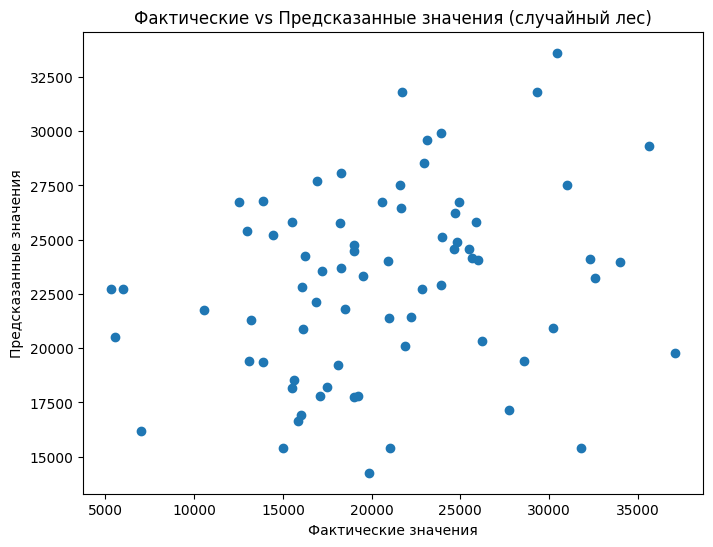

In [89]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf)
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title('Фактические vs Предсказанные значения (случайный лес)')
plt.show()

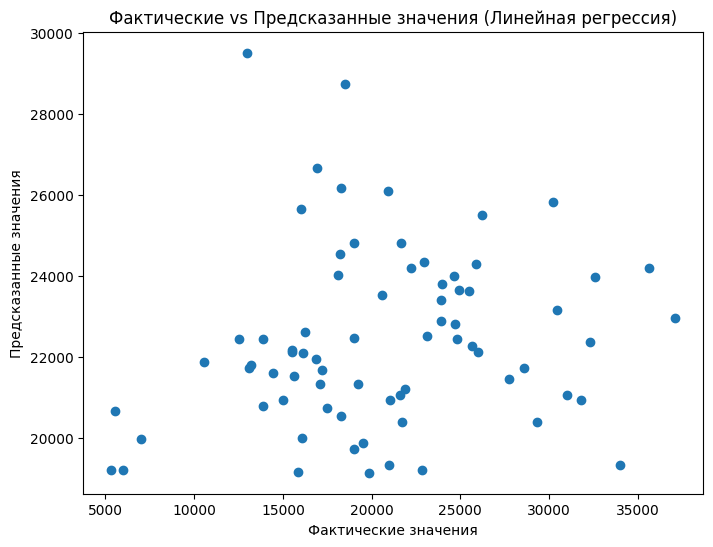

In [90]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lin_reg)
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title('Фактические vs Предсказанные значения (Линейная регрессия)')
plt.show()

### Общий вывод:

- Случайный лес может обеспечивать более высокую гибкость и способность выявлять более сложные паттерны, но в данном случае он не всегда точен в предсказаниях.
- Линейная регрессия предоставляет более стабильные результаты, с меньшими отклонениями от фактических значений, что может свидетельствовать о более простой или линейной природе зависимостей в данных.

### Заключение:

Это исследование может быть полезно широкой аудитории, включая политиков, образовательных специалистов, бизнесменов и исследователей, поскольку предоставляет информацию о том, как различные социально-экономические факторы влияют на жизнь людей, и помогает принимать обоснованные решения в разных сферах жизни.